# Installing dependencies

In [1]:
!pip install node2vec
!pip install pycountry

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 43.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
mlxte

# Imports

In [2]:
import os
import random

#Data
import numpy as np
import pandas as pd
import re
import json
import math

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from tqdm import tqdm

# Models
from kaggle_secrets import UserSecretsClient
from openai import AzureOpenAI
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from node2vec import Node2Vec
import torch
import torch.nn as nn
import torch.nn.functional as F
import umap

#Metrics
import pycountry
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

#Transformations
from sklearn.preprocessing import normalize
import networkx as nx
from itertools import combinations
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
from itertools import combinations
from collections import Counter
import ast

2025-06-27 02:54:13.328204: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750992853.576160      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750992853.650061      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Policy Embeddings
In this notebook, I vectorized each nation's political stance by:
- cleaning text
- embedding country speeches with semantic segmentation and averaging
- graph based knowledge embedding utilzied country information such as: political bloc, voting record
- combining vectors

# Cleaning Text

In [3]:
# Function for cleaning data

def clean_text(text: str) -> str:
    """Clean text by removing country names while preserving stopwords"""
    print("Cleaning text")
    country_names = [
        "Afghanistan", "Albania", "Algeria", "Andorra", "Angola", 
        "Antigua", "Argentina", "Armenia", "Australia", "Austria",
        "Azerbaijan", "Bahamas", "Bahrain", "Bangladesh", "Barbados",
        "Belarus", "Belgium", "Belize", "Benin", "Bhutan",
        "Bolivia", "Bosnia", "Botswana", "Brazil", "Brunei",
        "Bulgaria", "Burkina", "Burundi", "Cambodia", "Cameroon",
        "Canada", "Cape Verde", "Central African Republic", "Chad", "Chile",
        "China", "Colombia", "Comoros", "Congo", "Costa Rica",
        "Croatia", "Cuba", "Cyprus", "Czech Republic", "Denmark",
        "Djibouti", "Dominica", "Dominican Republic", "Ecuador", "Egypt",
        "El Salvador", "Equatorial Guinea", "Eritrea", "Estonia", "Eswatini",
        "Ethiopia", "Fiji", "Finland", "France", "Gabon",
        "Gambia", "Georgia", "Germany", "Ghana", "Greece",
        "Grenada", "Guatemala", "Guinea", "Guinea-Bissau", "Guyana",
        "Haiti", "Honduras", "Hungary", "Iceland", "India",
        "Indonesia", "Iran", "Iraq", "Ireland", "Israel",
        "Italy", "Ivory Coast", "Jamaica", "Japan", "Jordan",
        "Kazakhstan", "Kenya", "Kiribati", "Korea", "Kosovo",
        "Kuwait", "Kyrgyzstan", "Laos", "Latvia", "Lebanon",
        "Lesotho", "Liberia", "Libya", "Liechtenstein", "Lithuania",
        "Luxembourg", "Madagascar", "Malawi", "Malaysia", "Maldives",
        "Mali", "Malta", "Marshall Islands", "Mauritania", "Mauritius",
        "Mexico", "Micronesia", "Moldova", "Monaco", "Mongolia",
        "Montenegro", "Morocco", "Mozambique", "Myanmar", "Namibia",
        "Nauru", "Nepal", "Netherlands", "New Zealand", "Nicaragua",
        "Niger", "Nigeria", "North Korea", "North Macedonia", "Norway",
        "Oman", "Pakistan", "Palau", "Panama", "Papua New Guinea",
        "Paraguay", "Peru", "Philippines", "Poland", "Portugal",
        "Qatar", "Romania", "Russia", "Rwanda", "Saint Kitts",
        "Saint Lucia", "Saint Vincent", "Samoa", "San Marino", "Sao Tome",
        "Saudi Arabia", "Senegal", "Serbia", "Seychelles", "Sierra Leone",
        "Singapore", "Slovakia", "Slovenia", "Solomon Islands", "Somalia",
        "South Africa", "South Korea", "South Sudan", "Spain", "Sri Lanka",
        "Sudan", "Suriname", "Sweden", "Switzerland", "Syria",
        "Taiwan", "Tajikistan", "Tanzania", "Thailand", "Timor-Leste",
        "Togo", "Tonga", "Trinidad", "Tunisia", "Turkey",
        "Turkmenistan", "Tuvalu", "Uganda", "Ukraine", "United Arab Emirates",
        "United Kingdom", "United States", "Uruguay", "Uzbekistan", "Vanuatu",
        "Vatican City", "Venezuela", "Vietnam", "Yemen", "Zambia", "Zimbabwe"
    ]
    
    country_names += [
        "USA", "UK", "UAE", "PRC", "DPRK", 
        "ROK", "DRC", "U.S.", "U.K.", "America",
        "Britain", "England", "Scotland", "Wales", "Northern Ireland",
        "Hong Kong", "Macau", "Palestine", "Ivory Coast", "Czechia",
        "Macedonia", "Swaziland", "Burma", "East Timor", "Vatican"
    ]
    text = re.sub(r'\b(?:the\s+)?(?:delegation\s+of\s+)?(?:representative\s+of\s+)?(' + 
                  '|'.join(country_names) + r')\b', '[COUNTRY]', text, flags=re.IGNORECASE)
    
    text = re.sub(r'[^\w\s\[\]]', ' ', text) 
    text = text.lower()

    text = ' '.join(text.split()).strip()
    
    return text[:3000]

# Semantic Segmentation using GPT 4o

In [4]:
def get_segments(text: str, max_tokens = 200) -> list[str]:
    paragraphs = [p for p in text.split('\n') if p.split()]

    num_seg = max(0, len(text.split())//max_tokens) + 3
    system =     system = f"""
    You will do semantic segmentation of the following text and output the result as a JSON string.
    Segment this diplomatic text into {num_seg} coherent policy segments.
    Each segment should focus on a single policy theme (e.g., economic policy, 
    security concerns, human rights, international cooperation).
    Preserve diplomatic context and policy coherence within each segment.
    
    Return the result as JSON with this exact format:
    {{"segments": ["segment1", "segment2", "segment3"]}}
    """
    print("Doing semantic segmentation...")
    response = client.chat.completions.create(
        model='gpt-4o',
        messages=[
            {"role": "system", "content": system},
            {"role": "user", "content": text}
        ],
        response_format={"type": "json_object"}
    )
    
    segments = json.loads(response.choices[0].message.content)["segments"]
    if not len(paragraphs) == 1:
        segments.append(paragraphs)
    segments.append(text)
    print(f"Generated {len(segments)} segments. ")
    return segments

In [5]:
user_secrets = UserSecretsClient()

api = user_secrets.get_secret("OPENAI_API_KEY")
client = AzureOpenAI(
    api_key=api,
    api_version="2024-11-01-preview",
    azure_endpoint="https://swedencentral.api.cognitive.microsoft.com"
)

# Ensemble Embeddings using text-embedding-3-large & bge-large-en-v1.5

In [6]:
def generate_embeddings(texts: list[str]):
    print("Generating embeddings for each segmentation")
    stm = SentenceTransformer('BAAI/bge-large-en-v1.5')
    embeddings = []
    for i in texts:
        bge = stm.encode(i)
        response = client.embeddings.create(
            model="text-embedding-3-large",
            input=i
        )
        emb1 = normalize([response.data[0].embedding])[0]
        emb2 = normalize([bge])[0]
        embedding = np.concatenate([emb1, emb2])
        embeddings.append(embedding)
    
    fin_emb = []
    
    for i in range(len(embeddings)):
        fin_emb.append(list(embeddings[i]))
    return fin_emb

# Generating embeddings for every country speech

In [7]:
df = pd.read_csv("/kaggle/input/better-speech-embeddings/country_embeddings_optimized.csv").transpose()
df2 = pd.read_csv("/kaggle/input/2-hour-speech-embedding-average-5200-speeches/my_file.csv")
df.columns = df2.columns
df.drop('Unnamed: 0', inplace=True)
df.index = range(0, 4096)

# Knowledge injecting using node graphs

In [8]:
IGO = pd.read_csv("/kaggle/input/political-igos/Major Political IGOs Expanded.csv")
IGO["Member Countries"] = IGO["Member Countries"].apply(lambda x: str(x.split("; ")))

organizations = {IGO.iloc[i]['IGO Name'] : IGO.iloc[i]['Member Countries'] for i in range(len(IGO))}

for k in organizations:
    if isinstance(organizations[k], str):
        organizations[k] = ast.literal_eval(organizations[k])


del organizations['United Nations (UN)']

In [9]:
voting = pd.read_csv("/kaggle/input/un-grouped-voting-data/Voting Data Groupings.csv")
voting["countries"] = voting["countries"].fillna('')
voting["countries"] = voting["countries"].apply(lambda x: x.split(";") if x else [])

votings = {voting.iloc[i]['resolution'] : voting.iloc[i]['countries'] for i in range(len(voting))}

In [10]:
socioeconomic = pd.read_csv("/kaggle/input/countries-of-the-world-2023/world-data-2023.csv")
socioeconomic = socioeconomic.rename(columns={'Country':'countries'})
socioeconomic = socioeconomic.drop(columns=[
    'Abbreviation',
    'Calling Code',
    'Capital/Major City',
    'Currency-Code',
    'Largest city',
    'Minimum wage',
    'Maternal mortality ratio',
    'Tax revenue (%)',
    'CPI Change (%)'
])
socioeconomic = socioeconomic.dropna()
socioeconomic = socioeconomic.apply(lambda x: x.astype(str).str.replace('%',''))
socioeconomic = socioeconomic.apply(lambda x: x.astype(str).str.replace(',',''))
socioeconomic = socioeconomic.apply(lambda x: x.astype(str).str.replace('$',''))

categorical = socioeconomic[['countries','Official language']]
socioeconomic = socioeconomic.drop(columns=['Official language'])

meta_df = socioeconomic.set_index('countries')
X = meta_df
X_scaled = StandardScaler().fit_transform(X)

sim_matrix = cosine_similarity(X_scaled)
countries = list(meta_df.index)

Computing transition probabilities:   0%|          | 0/208 [00:00<?, ?it/s]

Generating walks (CPU: 2): 100%|██████████| 150/150 [00:39<00:00,  3.83it/s]


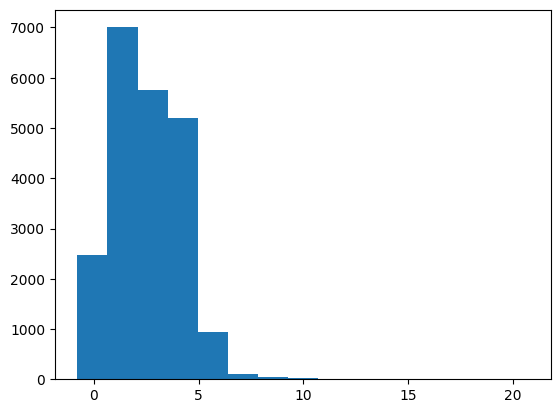

In [11]:
edge_counter = Counter()

imp_org = [
    "European Union (EU)",
    "North Atlantic Treaty Organization (NATO)",
    "Shanghai Cooperation Organisation (SCO)",
    "BRICS",
    "G7",
    "G20",
    "Non-Aligned Movement (NAM)",
    "Organization of Islamic Cooperation (OIC)",
    "G77"
]

for org_name, members in organizations.items():
    if org_name in imp_org:
        org_weight = 10 / len(members) * 3
    else:
        org_weight = 10 / len(members)
    for pair in combinations(members, 2):
        edge_counter[pair] += org_weight

for members in votings.values():
    for pair in combinations(members, 2):
        edge_counter[pair] += 0.001

for i, country_i in enumerate(countries):
    for j in range(i+1, len(countries)):
        country_j = countries[j]
        similarity = sim_matrix[i][j]
        edge_counter[(country_i, country_j)] += similarity

plt.hist(dict(edge_counter).values(), bins=15)

G = nx.Graph()
for (u, v), w in edge_counter.items():
    G.add_edge(u, v, weight=w)

node2vec = Node2Vec(G, dimensions=128, walk_length=40, num_walks=300, 
                    p=1, q=0.25, weight_key='weight', workers=2)

model = node2vec.fit(window=10, min_count=1, batch_words=4)

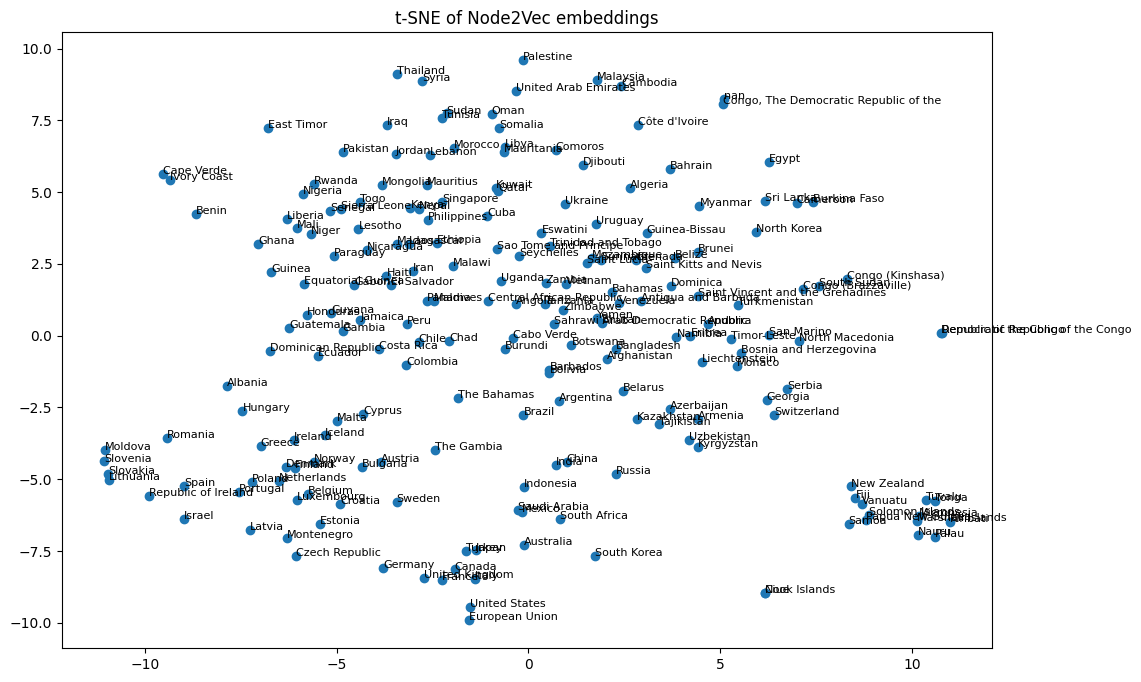

In [12]:
vecs = np.array([model.wv[country] for country in model.wv.index_to_key])
labels = model.wv.index_to_key

tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(vecs)

plt.figure(figsize=(12, 8))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1])

for i, label in enumerate(labels):
    plt.annotate(label, (emb_2d[i, 0], emb_2d[i, 1]), fontsize=8)

plt.title("t-SNE of Node2Vec embeddings")
plt.show()

In [13]:
def get_organizations(country: str):
    return [igo for igo, members in organizations.items() if country in members]

In [14]:
df = df.drop(columns=['Holy See (Vatican City State)', 'Congo', 'Czechia', 'Congo, The Democratic Republic of the'])
df = df.rename(columns={'Viet Nam': 'Vietnam', 'Brunei Darussalam': 'Brunei','Iran, Islamic Republic of': 'Iran',"Lao People's Democratic Republic": 'Laos','Türkiye': 'Turkey','Syrian Arab Republic': 'Syria','Russian Federation': 'Russia', 'Palestine, State of': 'Palestine', 'Korea, Republic of': 'South Korea', "Korea, Democratic People's Republic of": 'North Korea', 'Bolivia, Plurinational State of': 'Bolivia', 'Moldova, Republic of': 'Moldova', 'Tanzania, United Republic of': 'Tanzania', 'Micronesia, Federated States of':'Micronesia', 'Venezuela, Bolivarian Republic of': 'Venezuela'})
for i in df.columns:
    if not i in list(model.wv.key_to_index.keys()):
        print(i)

In [15]:
#df = df.drop(columns=['Bolivia, Plurinational State of', 'Brunei Darussalam'])
countries = list(df.columns)
graph_data = []
speech_data = []
for country in countries:
    graph_data.append(list(model.wv[country]))
    speech_data.append(list(df[country]))

graph_data = np.array(graph_data)
speech_data = np.array(speech_data)

# Combining speech embeddings and knowledge based embeddings

In [16]:
# --- 1. Define Model ---
class VectorInjector(nn.Module):
    def __init__(self, dim=512, hidden_dim=256):
        super().__init__()
        self.fc1 = nn.Linear(dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, dim)

    def forward(self, x):
        h = F.relu(self.bn1(self.fc1(x)))
        h = F.relu(self.bn2(self.fc2(h)))
        out = self.fc3(h) + x  # Residual connection
        return out

# --- 2. Distance Matrix Function (Euclidean) ---
def euclidean_distance_matrix(vectors):
    return torch.cdist(vectors, vectors, p=2)  # shape (N x N)

# --- 3. Matrix Loss Function ---
def matrix_distance_loss(pred_vectors, target_matrix):
    pred_dists = euclidean_distance_matrix(pred_vectors)
    return F.mse_loss(pred_dists, target_matrix)

# --- 4. Train Function ---
def train_to_match_umap_geometry(speech_data, graph_data, umap_dim=100, epochs=200, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Step 1: Compute UMAP of graph embeddings
    graph_umap = umap.UMAP(n_components=umap_dim, random_state=42).fit_transform(graph_data)

    # Step 2: Compute pairwise Euclidean distances in UMAP space
    with torch.no_grad():
        umap_dists = squareform(pdist(graph_umap, metric='euclidean'))
        A = torch.tensor(umap_dists, dtype=torch.float32).to(device)

    # Step 3: Prepare input
    speech_tensor = torch.from_numpy(speech_data).float().to(device)

    # Step 4: Initialize model
    model = VectorInjector(dim=speech_data.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Step 5: Training loop
    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()
        transformed = model(speech_tensor)
        loss = matrix_distance_loss(transformed, A)
        loss.backward()
        optimizer.step()

        if epoch % 25 == 0 or epoch == 1:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

    return model, graph_umap

# --- 5. Get Transformed Embeddings ---
def get_transformed_embeddings(model, speech_data):
    model.eval()
    with torch.no_grad():
        device = next(model.parameters()).device
        input_tensor = torch.from_numpy(speech_data).float().to(device)
        output_tensor = model(input_tensor)
    return output_tensor.cpu().numpy()

# --- 6. Evaluation Utility ---
def matrix_distance(A, B):
    return np.mean((A - B) ** 2)

def print_similarity_quality(transformed, graph_umap):
    ts = transformed / np.linalg.norm(transformed, axis=1, keepdims=True)
    gu = graph_umap / np.linalg.norm(graph_umap, axis=1, keepdims=True)
    dist_ts = squareform(pdist(ts, 'euclidean'))
    dist_gu = squareform(pdist(gu, 'euclidean'))
    print("MSE between Euclidean distance matrices:", matrix_distance(dist_ts, dist_gu))

trained_model, graph_umap = train_to_match_umap_geometry(speech_data, graph_data)
transformed_speech = get_transformed_embeddings(trained_model, speech_data)
print_similarity_quality(transformed_speech, graph_umap)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Epoch 1, Loss: 803.292236
Epoch 25, Loss: 7.806689
Epoch 50, Loss: 1.427488
Epoch 75, Loss: 0.753267
Epoch 100, Loss: 0.561100
Epoch 125, Loss: 0.468002
Epoch 150, Loss: 0.405362
Epoch 175, Loss: 0.357843
Epoch 200, Loss: 0.320139
MSE between Euclidean distance matrices: 0.4236667788822862


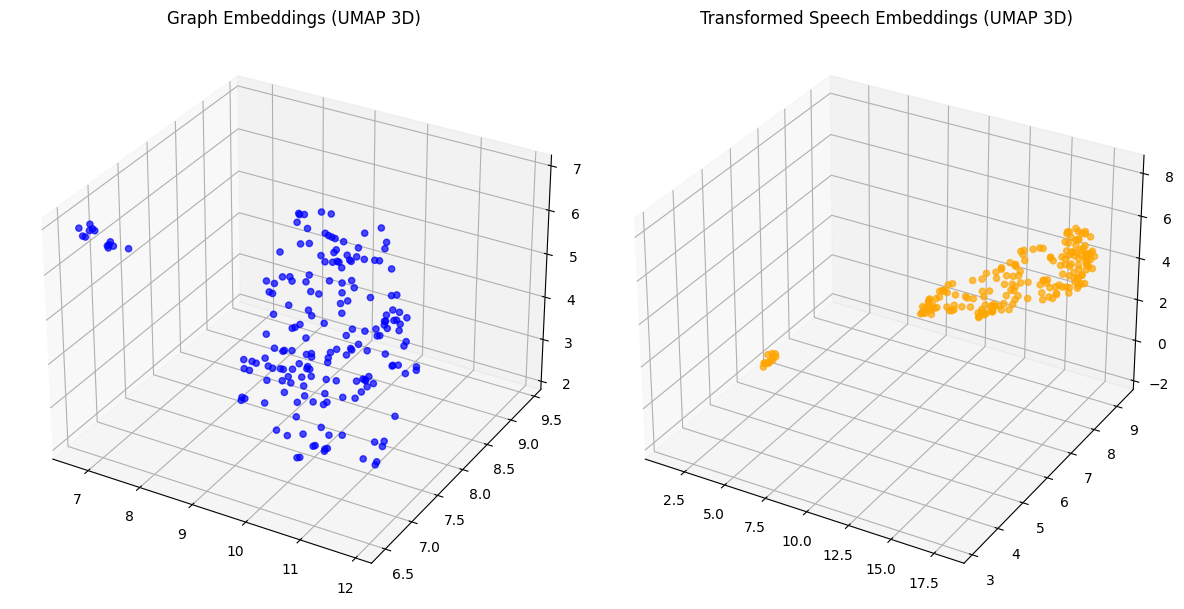

In [17]:
from mpl_toolkits.mplot3d import Axes3D

# Reduce to 3D for plotting
graph_umap_3d = umap.UMAP(n_components=3).fit_transform(graph_data)
transformed_3d = umap.UMAP(n_components=3).fit_transform(transformed_speech)

fig = plt.figure(figsize=(12, 6))

# --- Graph Embeddings ---
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_title("Graph Embeddings (UMAP 3D)")
ax1.scatter(graph_umap_3d[:, 0], graph_umap_3d[:, 1], graph_umap_3d[:, 2], c='blue', alpha=0.7)

# --- Transformed Speech Embeddings ---
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title("Transformed Speech Embeddings (UMAP 3D)")
ax2.scatter(transformed_3d[:, 0], transformed_3d[:, 1], transformed_3d[:, 2], c='orange', alpha=0.7)

plt.tight_layout()
plt.show()

In [18]:
combined_embedding = torch.reshape(torch.tensor(transformed_speech), (4096, 190))

np_array = combined_embedding.detach().cpu().numpy()
final_country_embeddings = pd.DataFrame(np_array, columns=countries)
final_country_embeddings

,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Kingdom,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
0,-0.030406,0.071200,-0.026319,0.029692,-0.021834,0.040873,-0.042147,0.006318,-0.071766,-0.025816,...,0.037337,0.050848,-0.052534,0.023235,-0.067936,0.055271,0.130507,-0.037785,0.046240,-0.021096
1,-0.008840,-0.040476,0.050270,0.098379,0.028788,0.006213,-0.045129,0.023343,0.017879,-0.024013,...,-0.028624,-0.061736,0.019972,-0.040265,0.028332,0.020760,0.036874,-0.037285,0.020339,-0.049019
2,0.011955,-0.018890,-0.063012,0.014370,-0.009335,0.078287,-0.033778,0.031085,0.059468,-0.079077,...,0.109423,0.031644,-0.023503,0.018883,-0.057992,0.057455,-0.091575,0.071386,0.061345,0.000846
3,0.054540,0.001728,0.049948,-0.008468,-0.063046,-0.051049,0.029421,0.012766,-0.065922,-0.041661,...,-0.053381,-0.018847,0.008089,-0.000194,-0.009529,0.042330,0.045363,0.007644,-0.045442,0.002930
4,-0.042402,-0.067948,0.050870,0.008604,-0.051480,-0.038852,0.009252,0.023169,0.038335,0.111351,...,-0.052563,0.074600,0.089655,0.032008,0.037202,-0.069400,-0.069800,-0.070447,0.008300,0.019929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,0.063061,0.021278,0.080606,0.074256,0.030512,-0.050739,0.012830,-0.012587,0.037733,-0.106919,...,-0.067392,0.076586,0.028261,0.066798,-0.063897,-0.010472,-0.002639,0.087919,0.026457,-0.085160
4092,-0.052423,0.089902,-0.087813,0.019094,-0.121720,-0.055350,-0.007779,-0.018352,0.043739,-0.012485,...,-0.050672,-0.012710,0.064398,-0.063434,0.036200,0.021067,0.103697,-0.089390,0.042385,0.103291
4093,0.042961,0.060500,0.007403,0.026838,-0.044684,-0.076136,0.052603,-0.024476,0.017474,-0.073801,...,0.007418,0.146688,0.040672,0.128376,-0.021390,-0.047944,0.042618,0.028733,0.000149,-0.038090
4094,-0.011092,0.026067,0.043699,0.041370,-0.042302,0.021726,-0.054832,-0.059851,-0.005730,-0.015270,...,-0.024892,0.133439,0.004686,0.006989,-0.019165,-0.066744,-0.081040,-0.030085,0.025088,0.007150


In [19]:
def compare_countries(country1, country2):
    cs = cosine_similarity(
        np.array(list(final_country_embeddings[country1])).reshape(1, -1),
        np.array(list(final_country_embeddings[country2])).reshape(1, -1)
    )
    return cs

# Visualizing and testing

(190, 128) (190, 4096)


Text(0.5, 1.0, 'Correlation Between Policy - Speech Embeddings')

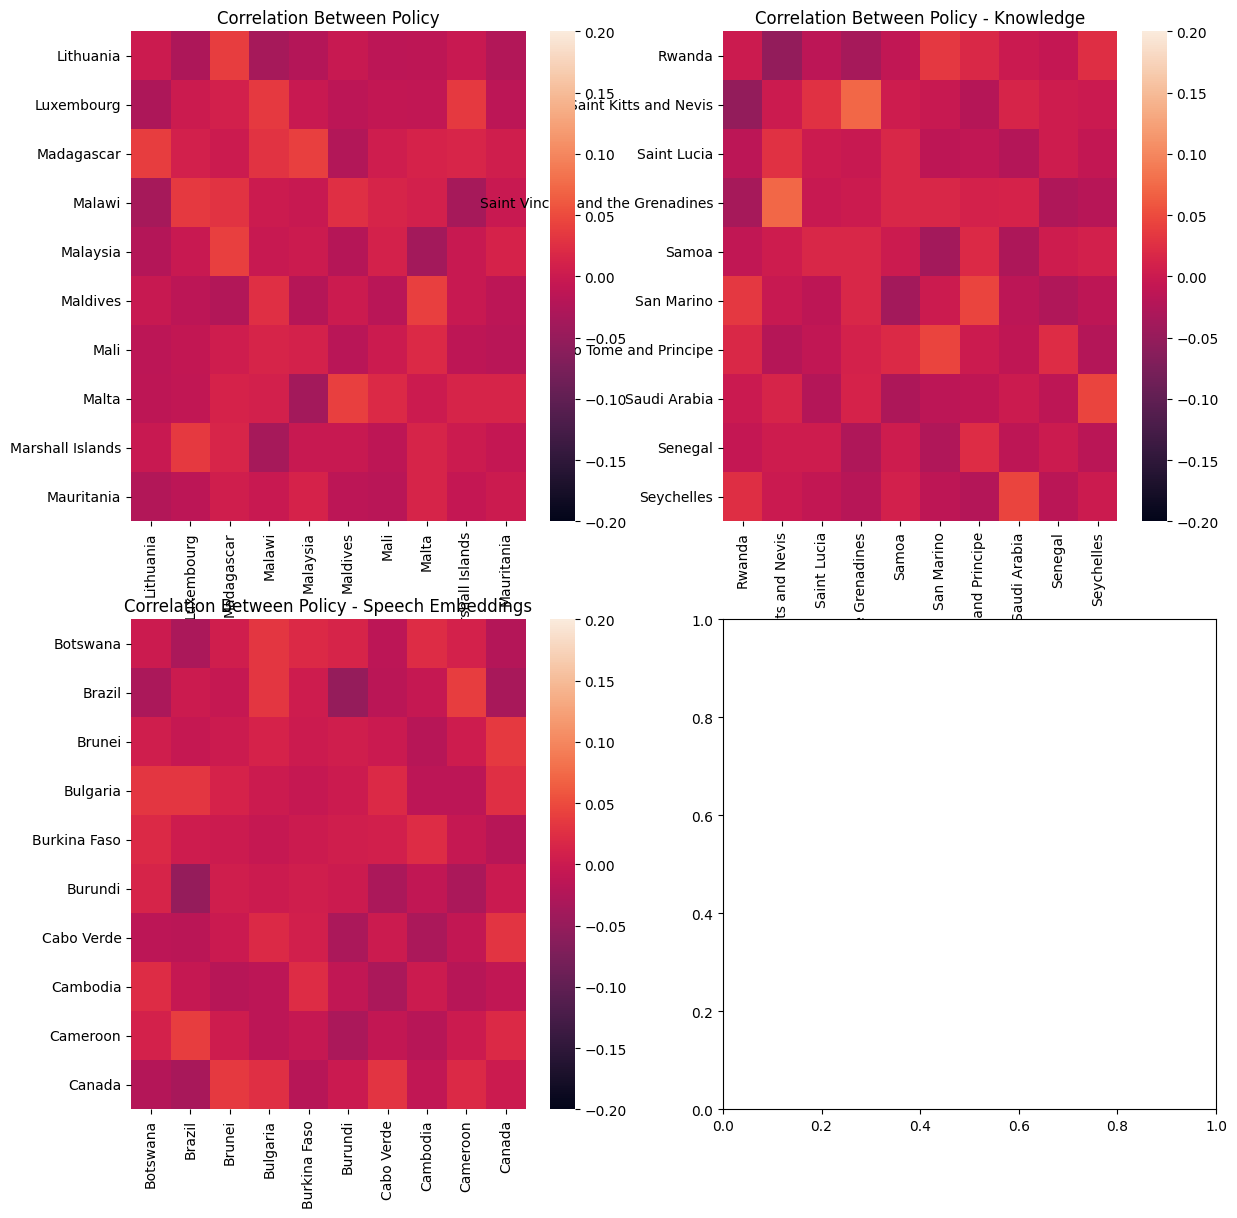

In [20]:
def get_corr_matrix(final_country_embeddings):
    start = random.randint(0, len(final_country_embeddings.columns)-10)
    corr_matrix = pd.DataFrame(
        index=final_country_embeddings.columns[start:start+10],
        columns=final_country_embeddings.columns[start:start+10],
        dtype=float
    )
    for i, country in enumerate(final_country_embeddings.columns[start:start+10]):
        for j, country_2 in enumerate(final_country_embeddings.columns[start:start+10]):
            if j > i:
                sim = compare_countries(country, country_2)
                corr_matrix.loc[country, country_2] = sim
                corr_matrix.loc[country_2, country] = sim
            elif j==i:
                corr_matrix.loc[country, country_2] = 0
    return corr_matrix

corr_matrix = get_corr_matrix(final_country_embeddings)
graph_data = np.array(graph_data)
speech_data = np.array(speech_data)
print(graph_data.shape, speech_data.shape)

graph_df = pd.DataFrame(graph_data.transpose(), columns=countries)
speech_df = pd.DataFrame(speech_data.transpose(), columns=countries)

graph_df = get_corr_matrix(graph_df)
speech_df = get_corr_matrix(speech_df)

fig, axes = plt.subplots(2, 2, figsize=(14, 14))
axes = axes.flatten()

minmax = 0.2

sns.heatmap(corr_matrix, annot=False, vmin=-minmax, vmax=minmax, ax=axes[0])
axes[0].set_title('Correlation Between Policy')

sns.heatmap(graph_df, annot=False, vmin=-minmax, vmax=minmax, ax=axes[1])
axes[1].set_title('Correlation Between Policy - Knowledge')

sns.heatmap(speech_df, annot=False, vmin=-minmax, vmax=minmax, ax=axes[2])
axes[2].set_title('Correlation Between Policy - Speech Embeddings')

In [21]:
umap_model = umap.UMAP(n_components=5, random_state=42)
graph_umap = umap_model.fit_transform(graph_data)
speech_umap = umap_model.fit_transform(final_country_embeddings)
or_speech_umap = umap_model.fit_transform(speech_data)

from scipy.spatial.distance import pdist, squareform

def get_distance_matrix(umap_embeddings, countries, sample_size=5):
    idx = sorted(random.sample(range(len(countries)), sample_size))
    selected = umap_embeddings[idx]
    dist_matrix = squareform(pdist(selected, metric='euclidean'))
    selected_countries = [countries[i] for i in idx]
    df = pd.DataFrame(dist_matrix, index=selected_countries, columns=selected_countries)
    return df

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Text(0.5, 1.0, 'UMAP Distance Between Country Policy Embeddings')

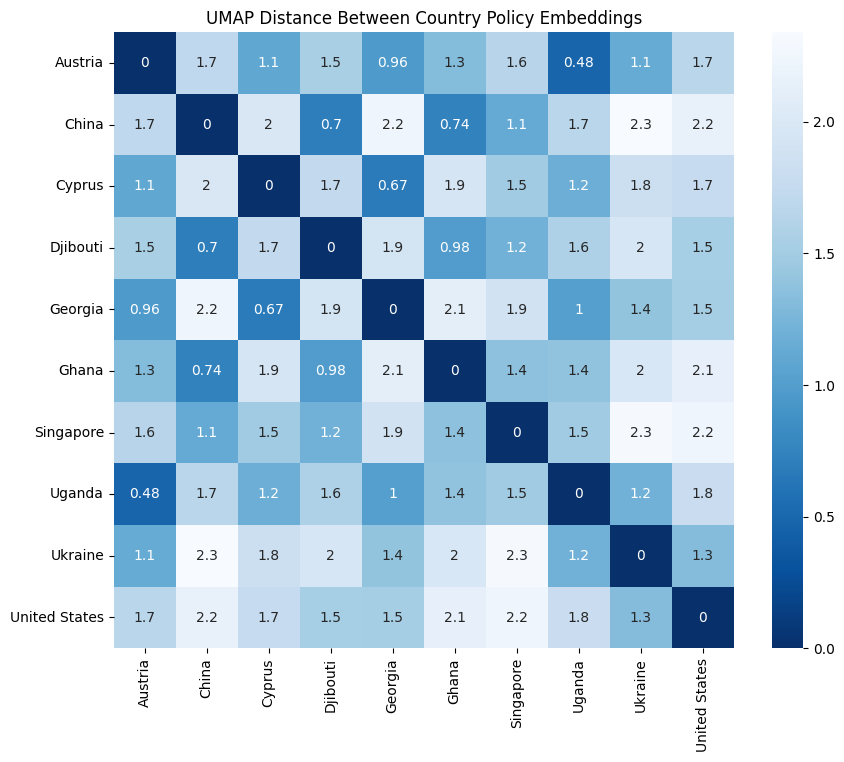

In [22]:
plt.figure(figsize=(10,8))

graph_umap_df = get_distance_matrix(graph_umap, countries, 10)
speech_umap_df = get_distance_matrix(speech_umap, countries, 10)
or_speech_umap_df = get_distance_matrix(or_speech_umap, countries, 10)

sns.heatmap(speech_umap_df, annot=True, vmin=0, vmax=None, cmap="Blues_r")
plt.title('UMAP Distance Between Country Policy Embeddings')

Text(0.5, 1.0, 'UMAP Distance in Knowledge Injection')

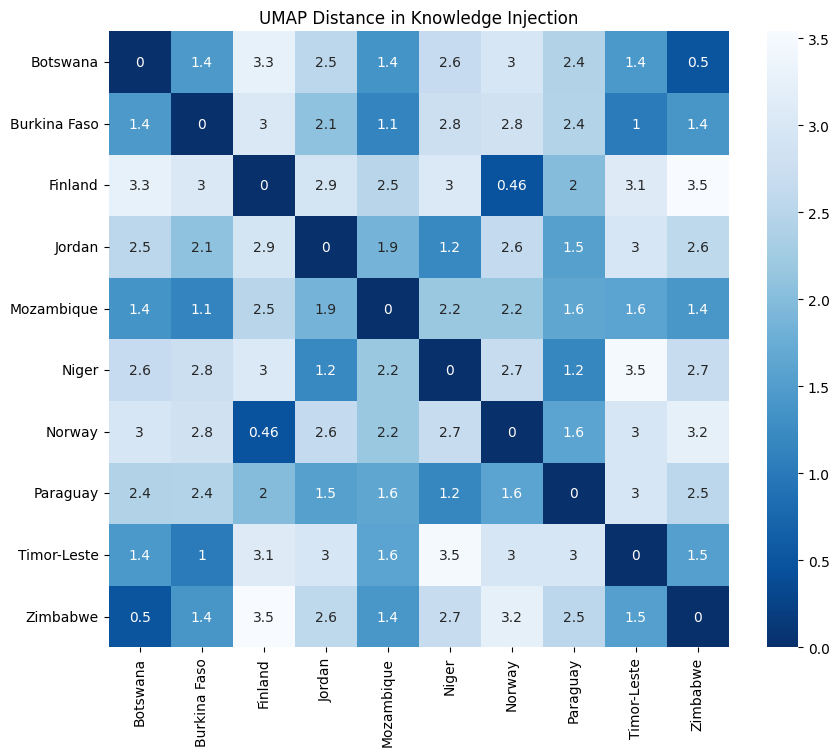

In [23]:
plt.figure(figsize=(10,8))
sns.heatmap(graph_umap_df, annot=True, vmin=0, vmax=None, cmap="Blues_r")
plt.title('UMAP Distance in Knowledge Injection')

Text(0.5, 1.0, 'UMAP Distance in Original Speech Embeddings')

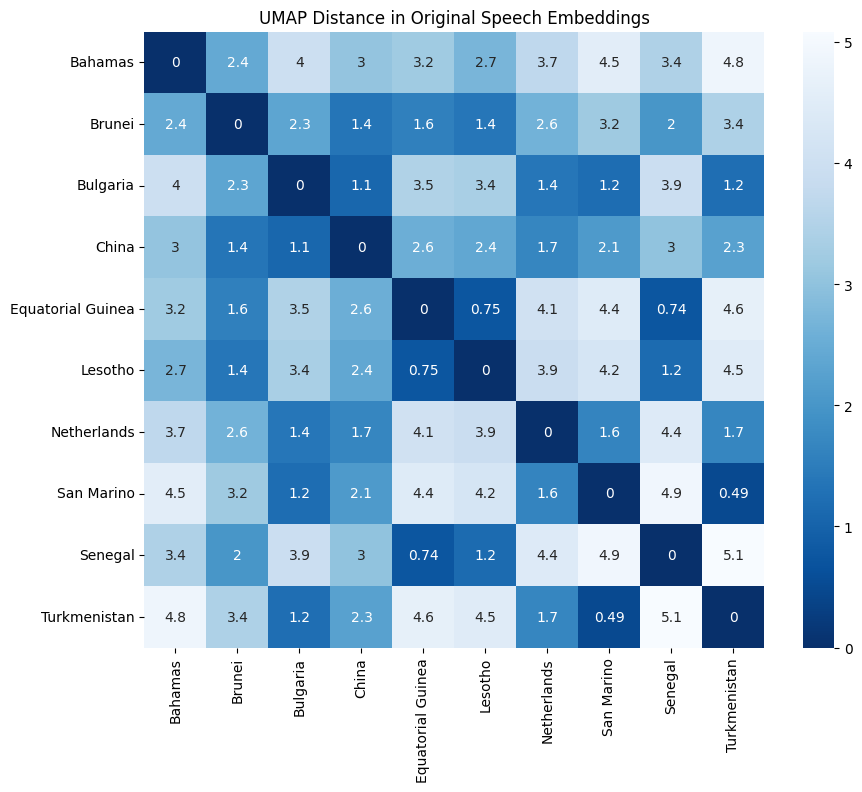

In [24]:
plt.figure(figsize=(10,8))
sns.heatmap(or_speech_umap_df, annot=True, vmin=0, vmax=None, cmap="Blues_r")
plt.title('UMAP Distance in Original Speech Embeddings')

In [25]:
full_umap = get_distance_matrix(graph_umap, countries, 190)

In [26]:
umap_projector = umap.UMAP(n_components=2, random_state=42)

def generate_country_similarity(speech: str, place: str):
    clean_speech = clean_text(speech)
    speechs = get_segments(clean_speech)
    or_encode = np.array(generate_embeddings(speechs))
    av_vec = np.mean(or_encode, axis=0)

    av_vec = np.expand_dims(av_vec, axis=0)
    with torch.no_grad():
        av_vec = get_transformed_embeddings(trained_model, av_vec)

    country_names = list(final_country_embeddings.columns)
    country_matrix = np.stack([final_country_embeddings[col] for col in country_names])

    all_vectors = np.vstack([av_vec, country_matrix])

    all_umap = umap_projector.fit_transform(all_vectors)
    speech_vec = all_umap[0]
    country_vecs = all_umap[1:]

    dists = euclidean_distances([speech_vec], country_vecs)[0]

    lis = list(zip(dists, country_names))
    sorted_data = sorted(lis, key=lambda x: x[0]) 
    print("\n\nPolicy Alignment Scores (negative natural logarithm):\nPlease be careful comparing alignment scores as it is non-linear\n")
    for dist, country in sorted_data:
        if country == place:
            print(f'\n\n-----{country}------\n\n')
            print(f"{-math.log(dist):.6f} — {country}")
            if -math.log(dist) > 0: print("You did a great job in policy alignment!!!")
            print("\n\n")
        else:
            print(f"{-math.log(dist):.6f} — {country}")

In [27]:
def get_country_stats(country: str, num: int):
    distances = full_umap[country].copy()
    closest_countries = distances[distances > 0].nsmallest(num)
    print(f"3 closest countries to {country}: (UMAP Euclidian Distance)")
    print(', '.join(closest_countries.keys()))
    print("\n")
    print(f"Socioeconomic statistics of {country} as of 2023")
    country_data = pd.DataFrame(socioeconomic[socioeconomic['countries']==country]).drop(columns=['countries']).rename(columns={'Density\n(P/Km2)': 'Density (P/Km2)'})
    print(''.join(f"   - {column}: {country_data.iloc[0][column]}\n" for column in country_data.columns))

In [28]:
MUN_speeches = pd.read_csv("/kaggle/input/mun-speech-dataset/MUN Speech Testing.csv")
index = random.randint(0, len(MUN_speeches)-1)
print(f"Policy similarities of speech:\n\n{MUN_speeches.loc[index]['Speech']} \n\nFrom delegate of nation: {MUN_speeches.loc[index]['Country']}\n\n")
print(f"\nBasic information about {MUN_speeches.loc[index]['Country']}:\n")
print(f"{MUN_speeches.loc[index]['Country']} is part of the following organizations")
print("".join(f"   - {organization}\n" for organization in get_organizations(MUN_speeches.loc[index]['Country'])))

get_country_stats(MUN_speeches.loc[index]['Country'], 3)

generate_country_similarity(MUN_speeches.loc[index]['Speech'], MUN_speeches.loc[index]['Country'])

Policy similarities of speech:

Today, we face a world marked by rapid technological advancements, and it is our collective responsibility to ensure these innovations serve the greater good of all nations. Honorable Chair and Esteemed Delegates, The Russian Federation stands ready to contribute to discussions that balance progress with prudence, particularly in the realm of Artificial Intelligence (AI) in K-12 education. It is essential that these technologies complement, rather than replace, the invaluable role of human educators. Crucially, Russia believes that the use of AI in education must respect state sovereignty. Every nation should have the right to regulate AI technologies according to its own priorities, values, and educational goals. This principle of sovereignty ensures that AI is implemented in ways that adhere to robust national regulations, rather than being driven by a one-size-fits-all global agenda. In closing, Russia stands ready to work with all nations to achieve 

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(




Policy Alignment Scores (negative natural logarithm):
Please be careful comparing alignment scores as it is non-linear

1.769311 — Israel
1.470100 — Central African Republic
1.399865 — Nepal
1.284340 — India
1.185034 — Singapore
1.086621 — Liberia
0.979130 — Bulgaria
0.803412 — North Korea
0.765084 — Uruguay
0.649823 — Chile
0.617295 — Malaysia
0.587436 — Dominican Republic
0.545789 — Guinea
0.495833 — Iraq
0.489451 — Burkina Faso
0.472320 — Rwanda
0.465969 — Guinea-Bissau
0.464350 — Brazil
0.463063 — Cabo Verde
0.392373 — Cameroon
0.358561 — Senegal
0.350663 — Timor-Leste
0.307766 — Morocco
0.300802 — Sierra Leone
0.296991 — Liechtenstein


-----Russia------


0.292008 — Russia
You did a great job in policy alignment!!!



0.286662 — Belize
0.259492 — Bangladesh
0.249900 — Maldives
0.249260 — New Zealand
0.245609 — Mauritius
0.244917 — Peru
0.209245 — Andorra
0.208830 — Comoros
0.152962 — Seychelles
0.112600 — Cambodia
0.104712 — Mali
0.099715 — Côte d'Ivoire
0.099365 — Kazakhstan
0